In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from surprise.model_selection import train_test_split
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans, KNNWithZScore
from surprise import accuracy

## 1. Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics)

In [2]:
data = pd.read_csv('ratings_Electronics.csv', header=None)

In [3]:
columnNames = ['userId', 'productId', 'rating','timestamp']
data.columns = columnNames
data.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
data.drop(columns = ['timestamp'],inplace=True)

In [5]:
data.head()

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
rating       float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [7]:
print('No. of unique users =', data['userId'].nunique())

No. of unique users = 4201696


In [8]:
print('No. of unique products =', data['productId'].nunique())

No. of unique products = 476002


In [9]:
data['rating'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64

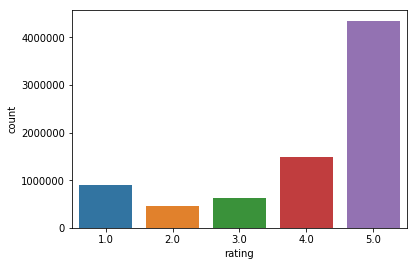

In [10]:
sns.countplot(data['rating'])

**Checking for missing values**

In [11]:
data.isna().sum()

userId       0
productId    0
rating       0
dtype: int64

## 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

Keeping only those users in the data, who have rated atleast 50 times.

In [12]:
data = data[data.groupby('userId')['userId'].transform('size') >= 50]

In [13]:
data.shape

(125871, 3)

Keeping only those products in the data, that have been rated atleast 20 times.

In [14]:
data = data[data.groupby('productId')['productId'].transform('size') >= 20]

In [15]:
data['userId'].nunique()

1512

In [16]:
data['productId'].nunique()

604

## 4. Build Popularity Recommender model.

**Doing some EDA**

In [17]:
data.groupby('productId')['rating'].mean().sort_values(ascending=False).head()  

productId
B0052SCU8U    4.979592
B0046TJG1U    4.958333
B00BW6KCTU    4.952381
B000F7QRTG    4.950000
B003ES5ZR8    4.933333
Name: rating, dtype: float64

In [18]:
data.groupby('productId')['rating'].count().sort_values(ascending=False).head()  

productId
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: rating, dtype: int64

**Creating a dataframe with average rating and the number of ratings for each product.**

In [19]:
ratings_mean_count = pd.DataFrame(data.groupby('productId')['rating'].mean()) 
ratings_mean_count['rating_count'] = pd.DataFrame(data.groupby('productId')['rating'].count()) 

In [20]:
ratings_mean_count.head()

,rating,rating_count
productId,,
B00004SB92,4.380952,21
B00004ZCJE,4.250000,72
B00005LEN4,4.709677,31
B00005T3G0,4.709677,31
B000067RT6,4.804878,41


**Sorting the products - by their rating_count first and then their rating**

In [21]:
ratings_mean_count.sort_values(by=['rating_count', 'rating'],ascending=False).head()

,rating,rating_count
productId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


**Sorting the products - by their rating first and then their rating_count**

In [22]:
ratings_mean_count.sort_values(by=['rating', 'rating_count'],ascending=False).head()

,rating,rating_count
productId,,
B0052SCU8U,4.979592,49
B0046TJG1U,4.958333,24
B00BW6KCTU,4.952381,21
B000F7QRTG,4.950000,20
B003ES5ZR8,4.933333,30


### Top - k Recommendations

In [23]:
k=5

Considering only those products which have been rated atleast 10% times of the max-rated product

In [24]:
max_ratings = ratings_mean_count['rating_count'].max()

In [25]:
threshold = 0.1*max_ratings

In [26]:
ratings_with_threshold = ratings_mean_count[ratings_mean_count['rating_count'] >= threshold]

In [33]:
print('The top 5 recommended products are:')
list(ratings_with_threshold.sort_values(by=['rating', 'rating_count'],ascending=False).head(k).index)

The top 5 recommended products are:


['B0052SCU8U', 'B0046TJG1U', 'B00BW6KCTU', 'B003ES5ZR8', 'B001TH7T2U']

## 3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [89]:
reader = Reader(rating_scale=(1,5))
data_surprise = Dataset.load_from_df(data,reader)

In [90]:
trainset, testset = train_test_split(data_surprise, test_size=.30, random_state=1)

Playing around with trainset

In [91]:
trainset.to_raw_uid(1)

'A2QAOP52OEB5EV'

In [92]:
trainset.to_raw_iid(1)

'B00DVFLJDS'

In [93]:
trainset.global_mean

4.368090706620773

## 5. Build Collaborative Filtering model.

#### User-User Collaborative Filtering

In [94]:
user_user_filter = KNNWithMeans(k=40, min_k=2, sim_options={'name': 'pearson_baseline', 'user_based': True})
user_user_filter.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [95]:
user_user_filter.predict(trainset.to_raw_uid(1),trainset.to_raw_iid(1))

Prediction(uid='A2QAOP52OEB5EV', iid='B00DVFLJDS', r_ui=None, est=1.0138848690102549, details={'actual_k': 2, 'was_impossible': False})

#### Item-Item Collaborative Filtering

In [96]:
item_item_filter = KNNWithMeans(k=40, sim_options={'name': 'pearson_baseline', 'user_based': False})
item_item_filter.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [97]:
item_item_filter.predict(trainset.to_raw_uid(2),trainset.to_raw_iid(2))

Prediction(uid='A2NOW4U7W3F7RI', iid='B0082E9K7U', r_ui=None, est=5, details={'actual_k': 11, 'was_impossible': False})

## 6. Evaluate both the models.

**RMSE for User-User model**

In [98]:
predicted_user_user = user_user_filter.test(testset)

In [99]:
accuracy.rmse(predicted_user_user)

RMSE: 0.9510


0.9510394173018636

**RMSE for Item-Item model**

In [100]:
predicted_item_item = item_item_filter.test(testset)

In [101]:
accuracy.rmse(predicted_item_item)

RMSE: 0.9720


0.9719696313413241

## 7. Get top - K ( K = 5) recommendations

#### Testset: We are recommending top (maximum 5) products for all users in the testset, based on user-user collaborative filtering

In [102]:
k=5

In [103]:
predicted_test = user_user_filter.test(testset)

In [104]:
def get_top_k(predictions, k=5):
    # First map the predictions to each user.
    top_k = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_k[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_k.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_k[uid] = user_ratings[:k]

    return top_k

In [105]:
top_k = get_top_k(predicted_test, k)

In [106]:
# Printing the recommended items for each user
print('The top (maximum 5) recommendations for each user in the testset are:')
print()
for uid, user_ratings in top_k.items():
    print(uid, ':',[iid for (iid, _) in user_ratings])

The top (maximum 5) recommendations for each user in the testset are:

A1MBXP3NZM2BUO : ['B00829THK0', 'B009HQCAPQ', 'B00E5UHRIO', 'B002MAPRYU', 'B007PRHNHO']
A1R76R4E6A8S3B : ['B008DWCRQW', 'B00829THK0', 'B00FH66AW4', 'B00ADG5FLK']
A3V2EZ6MA32FF6 : ['B008LCYIEI', 'B002TLTE6O', 'B0081H8TRA', 'B00DDK1QUC', 'B002HWRJY4']
A3GX0FAMEXV6FB : ['B005CT56F8', 'B002SZEOLG', 'B000QUUFRW']
A3S0DBBR693O06 : ['B0088CJT4U', 'B00EUFP39E']
A3J029KBNG5MNP : ['B004CLYEH8', 'B0034CL2ZI', 'B00829TIEK', 'B003RRYAXQ']
A141R97FHSSUQ0 : ['B000Z80ICM', 'B00AJHDZSI', 'B000F9YN22', 'B00BSEV682', 'B00E98O7GC']
AR6APXLK7TJU2 : ['B00009R6TA', 'B00829TIA4', 'B001CHHVCU', 'B000AZ57M6']
AFFVUZEGP1FDQ : ['B00IX2VGFA', 'B004MSQZUU', 'B00G4V0QSK', 'B004IZN3WU', 'B004NY9UV4']
A1PV5T5S4D5NPI : ['B005HMKKH4', 'B007WTAJTO', 'B0044YU60M', 'B00316263Y', 'B000LRMS66']
A2QDOJFFLFGF18 : ['B008ULPAT2', 'B0002L5R78', 'B00AYTW80M', 'B008X9Z8NE', 'B005DOUJL8']
A3QX0ERX4D03TF : ['B002Y6CJJ8', 'B009USAJCC']
A36K2N527TXXJN : ['B00IX2VGFA

A2EHYCA29NSQLU : ['B0028Y4CWI', 'B000LRMS66', 'B00829TIA4']
A1J87SYB3JPQWH : ['B0013FW8XS', 'B004RORMF6', 'B0036Q7MV0']
A23E9QQHJLNGUI : ['B00DR8LAE2', 'B00BP5KOPA']
ABUE0ALHKWKHC : ['B004CLYEH8', 'B00DIFIM36', 'B0038W0K2K', 'B00426C57O', 'B003B4CU3M']
AUITG1DJ3QUGK : ['B008ULPAT2', 'B00829TIEK', 'B00HFAEBWG', 'B005A0B7CA', 'B00004SB92']
A9ELHLPXF7JKD : ['B004T9RR6I', 'B0034CL2ZI', 'B002MAPRYU', 'B00006JN3G', 'B00JP12170']
A3R4794K2RVU1S : ['B00B99JU5M', 'B00D68ZVY8', 'B002QEBMAK', 'B005HMKKH4', 'B005CT56F8']
A1901NTE8LFJF6 : ['B0017TFVUW', 'B002KKFP9Y', 'B002JQNXZC', 'B000M2TAN4', 'B0034XRDUA']
A1GYEGLX3P2Y7P : ['B00JC5Y6WM', 'B002K9IHGI', 'B004CLYEE6', 'B007ZZ6OW6', 'B002R5AM7C']
A1VFX417XDNWIU : ['B00B99JU5M', 'B00EXPNFQO', 'B00E6ONJJU', 'B00DBX371C']
A2AFTRU43PY9P5 : ['B001TH7GSW', 'B0046TJG1U']
AK3GKIV8DEY8B : ['B001L6LG5K', 'B000Q8UAWY']
A2S26YGSVXBCFL : ['B00DBX371C', 'B008X9ZBVI', 'B00AYTW80M', 'B005GOINEK', 'B0079TOEQQ']
A32NEDX6UVV8DE : ['B003FVVMS0', 'B005CLPP8E', 'B009HQCAR

A1C82BC5GNABOA : ['B0013FRNKG']
A2VH0UT5EQFB6P : ['B005DOUJL8', 'B001TH7GSW', 'B00FFZD51Q']
A2IIAQ7VVAHXTD : ['B009SYZ8OC', 'B001TH7T2U', 'B004Q3R9AQ', 'B001XURP7W']
A1EOTB1WHLSW6G : ['B00DR8LAE2', 'B000JE7GPY']
A1ZXMMQPYC3Z9I : ['B000VX6XL6']
A1VR1HIOVQWN09 : ['B00B46XUQU', 'B000067RT6']
A2EW01G2LNJN06 : ['B004QK7HI8', 'B000X24ISU']
A3D7BGK0P5QY0X : ['B00429N18S']
A3077MQTAKOVFZ : ['B003YKG2XM', 'B001F7AHOG']
A6KL17KKN0A5L : ['B000JE7GPY']
A16HXVNPU5TCGE : ['B002WE6D44']
A3JU16JTNLVK1J : ['B00009R6TA', 'B004TJ6JH6']
AGATRDOFW48DK : ['B004RORMF6']
A17NVM7IAPF2NS : ['B003MAJMXQ', 'B004WK3U9W', 'B008X9Z6EA', 'B00BWL33H8', 'B003ELYQGG']
A22R9L5DAVYYWR : ['B000OGX5AM', 'B001NJ0D0Y', 'B004Q0PT3I']
A8X478DM3KAWM : ['B000N99BBC']
A259MPG6SOL02P : ['B009SYZ8OC', 'B001QUA6RA']
A34LQ791ACZ0JC : ['B0026ZPFCK', 'B000N99BBC']
A3S3VSXEFXBMRC : ['B0015DYMVO']
AHD3NZHDUZ5I6 : ['B001D7REIK', 'B002WE6D44']
A2XX2A4OJCDNLZ : ['B00IX2VGFA', 'B00005T3G0', 'B000BQ7GW8']
A16RL0RMRF974O : ['B00JC5Y6YA']
A1HSM9

#### Full Dataset: We are recommending top 5 products for all users in the entire dataset, based on user-user collaborative filtering

In [107]:
full_trainset = data_surprise.build_full_trainset()

In [108]:
user_user_filter2 = KNNWithMeans(k=40, min_k=2, sim_options={'name': 'pearson_baseline', 'user_based': True})
user_user_filter2.fit(full_trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [109]:
predictions_list = list()
for user in full_trainset.all_users():
    for item in full_trainset.all_items():
        raw_uid = full_trainset.to_raw_uid(user)
        raw_iid = full_trainset.to_raw_iid(item)
        predictions_list.append(user_user_filter2.predict(raw_uid,raw_iid))

In [110]:
top_k_train = get_top_k(predictions_list, 5)

In [111]:
# Printing the recommended items for each user
print('The top (maximum 5) recommendations for each user in the trainset are:')
print()
for uid, user_ratings in top_k_train.items():
    counter = counter + 1
    print(uid, ':',[iid for (iid, _) in user_ratings])

The top (maximum 5) recommendations for each user in the trainset are:

A3EZEP0FX5BC1P : ['B00017LSPI', 'B000CKVOOY', 'B000F9YN22', 'B000LRMS66', 'B000VX6XL6']
ATDE9JYCPI0L1 : ['B001T9NUJE', 'B008X9Z8NE', 'B003NR57BY', 'B00004SB92', 'B00029U1DK']
A14JBDSWKPKTZA : ['B00005LEN4', 'B00006JN3G', 'B00006RVPW', 'B00007EDZG', 'B000089GN3']
A2X8KN82L07RSK : ['B00E0EY7Z6', 'B001OC6DCW', 'B000M17AVO', 'B00825BZUY', 'B005HMKKH4']
ALUNVOQRXOZIA : ['B009PK9S90', 'B00AAIPT76', 'B000OGX5AM', 'B005CT56F8', 'B007WTAJTO']
AMKNPIDFLRFMP : ['B004XZHY34', 'B007PJ4PKK', 'B003VAHYNC', 'B008JJLW4M', 'B001OC6DCW']
A3GFQHHVMEAIO : ['B00004SB92', 'B00004ZCJE', 'B00005LEN4', 'B00005T3G0', 'B000067RT6']
A1JWSDDIH5Z7DV : ['B00004SB92', 'B00004ZCJE', 'B00005LEN4', 'B00005T3G0', 'B000067RT6']
A2SL5IW096Z2BL : ['B00006B7DA', 'B000CKVOOY', 'B000LRMS66', 'B000N99BBC', 'B000QUUFRW']
AUITG1DJ3QUGK : ['B00006JN3G', 'B0002CPBWI', 'B000IF51UQ', 'B000RZQZM0', 'B001TH7T2U']
A5JLAU2ARJ0BO : ['B0013FRNKG', 'B002TMRZOQ', 'B003ES5

A2H4OMJLE7JFM2 : ['B00004SB92', 'B00006JN3G', 'B00006RVPW', 'B00007E7JU', 'B0000BZL1P']
A2XXBZPQT5EXHV : ['B00005LEN4', 'B00006JN3G', 'B00006RVPW', 'B00007IFED', 'B00009XVCZ']
A3284KYDZ00BZA : ['B004XZHY34', 'B00E0EY7Z6', 'B00FJRS5BA', 'B009F7IBZK', 'B00BW6KCTU']
A35A2RWUMC737N : ['B00004SB92', 'B00004ZCJE', 'B00005LEN4', 'B00005T3G0', 'B000067RT6']
A3VC74TJ06WDDD : ['B000067RT6', 'B00006JN3G', 'B00009XVCZ', 'B000A6PPOK', 'B000BQ7GW8']
ABVYGB2TKBO8F : ['B00005T3G0', 'B00006JN3G', 'B00007E7JU', 'B00017LSPI', 'B00077AA5Q']
A26EQ8U96JA92T : ['B00005LEN4', 'B00005T3G0', 'B00006RVPW', 'B000089GN3', 'B0001Y7UAI']
A1NAA1R38JSNHV : ['B00004SB92', 'B00004ZCJE', 'B00005LEN4', 'B00005T3G0', 'B000067RT6']
A3IRA0BHI9NE9U : ['B00004SB92', 'B00005LEN4', 'B00005T3G0', 'B000067RT6', 'B00006B7DA']
A33SX0AD5PYD9B : ['B000JE7GPY', 'B000RZQZM0', 'B000S5Q9CA', 'B002HWRJBM', 'B002TLTE6Y']
A3HH340REI4J47 : ['B001TH7GUU', 'B00461E7JE', 'B000R9AAJA', 'B004Q0PT3I', 'B000BQ7GW8']
A21I62TCDL4754 : ['B000N99BBC', '

A2V2URLB31HG59 : ['B00007EDZG', 'B000BQ7GW8', 'B000KO0GY6', 'B000N99BBC', 'B000QUUFRW']
A27GITTN6AVW5I : ['B000CKVOOY', 'B0017JY5FE', 'B001DJ9GOS', 'B002V8C3W2', 'B003BLQHN4']
A2EF8N7ZE7ONWX : ['B00077AA5Q', 'B000BTL0OA', 'B000TG4BA0', 'B000VX6XL6', 'B001OC6DCW']
A2J8DE8R94ZB02 : ['B000RZQZM0', 'B00EOI2SR2', 'B001F51G16', 'B003ES5ZR8', 'B003VAHYNC']
ACSX5AIZE3MJ9 : ['B000S5Q9CA', 'B0017JY5FE', 'B002HWRJBM', 'B004SBBD8U', 'B008JJLW4M']
AXYM52DNK6NDF : ['B000L47AHG', 'B000N99BBC', 'B000S5Q9CA', 'B001T9NUJE', 'B002WE6D44']
A361U4SXK7FCQE : ['B00004SB92', 'B00005LEN4', 'B00007IFED', 'B000089GN3', 'B0000X0VCY']
A2DIQTZPF26T1L : ['B00006JN3G', 'B00007E7JU', 'B0000X0VCY', 'B000EVSLRO', 'B000MX48VM']
A2UTZ4O5E2W4DK : ['B000EVSLRO', 'B0019EHU8G', 'B002JQNXZC', 'B002WE6D44', 'B0043CVH2Q']
AV8MDYLHHTUOY : ['B00005LEN4', 'B00006RVPW', 'B00007EDZG', 'B00017LSPI', 'B0002CPBWI']
A3SP7T2PZ3HSDE : ['B00D6XW62I', 'B00COF7DGS', 'B000S5Q9CA', 'B00D429Y12', 'B001TH7GVE']
A316XO4RWX21YN : ['B0002LEMWE', 'B0

## 8. Summarise your insights.

### Popularity Model

We learnt how to build a popularity-based recommeder system by taking care of two things: 
1. The number of ratings each product has.
2. The average rating for each product.

We then recommended the top 5 products based on their average rating, by considering only those products which had a minimum number of ratings (above a certain threshold).

### Collaborative Filtering

We learnt how to build a collaborative filtering model using the surprise library. <br>
We split the data into trainset and testset, and built two models on the trainset:
1. User based
2. Item based

We then evaluated both the models on the testset using RMSE as the metric.

We finally learnt how to recommend top products to any user in the test set. This was done by iterating over the predictions returned from the testset, getting the rating estimates for each product for each user and sorting the ratings in the descending order.

We also built an algorithm to get recommendations for 'any' user in the dataset, by loading the entire dataset as the trainset and fitting the model on the entire trainset. We then fetched the top 5 recommendations for each user in the trainset.